# THIS CODE CONCATENATES WITH INVERSE VAR WEIGHTING

In [22]:
from astropy.table import Table, vstack, Column, MaskedColumn, pprint
import numpy as np

import matplotlib 
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Gaussian1DKernel

from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages

import os
import requests
import sys
sys.path.append('/Users/s2537809/DESI/desispec/py')
sys.path.append('/Users/s2537809/DESI/desimodel/py')
sys.path.append('/Users/s2537809/DESI/desitarget/py')
sys.path.append('/Users/s2537809/DESI/desiutil/py')

#from desispec.io import read_spectra
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra


from scipy import interpolate
import astropy.units as u
path='/Users/s2537809/Documents/DESI-STACKING'#specify code directory
os.chdir(path)
import stack_code as sc
import importlib
import fnmatch
import extinction as ext
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.modeling import models
from astropy.table import Table
from matplotlib import gridspec
import spectres
import time
import warnings

#pip install lmfit, extinction, sfdmap, spectres

import pandas as pd
crossmatch = Table.read('crossmatch_classifications.fits', format = 'fits' )

In [23]:
""" 
Remove the objects with failed redshfit classifications.
First appplying their ZWARN flag, then with the photo-z quality flag.
"""

# Apply ZWARN Flag cut
crossmatch = crossmatch[crossmatch['ZWARN'] == 0]

# Create photo-z quality flag
crossmatch['Z_CHECK']= (crossmatch['Z']-crossmatch['Z_BEST_1'])/(1+crossmatch['Z'])
crossmatch['Z_FAILURE'] = 0  
crossmatch['Z_FAILURE'][abs(crossmatch['Z_CHECK']) > 0.1] = 1 

# Apply photo-z quality flag
crossmatch = crossmatch[crossmatch['Z_FAILURE'] == 0]
print(len(crossmatch))
print(len(crossmatch[crossmatch['Z'] < 0]))

7533
27


## Cell below verifies if Spectra are downloaded and downloads if they aren't

Only run if unsure if spectra are downloaded, to save time!

In [2]:
"""
Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

"""


Overall_class = 'SFG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][1000:1200]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])



def select_data(table, column_name, search_values):
    # Get the column data as a numpy array
    column_data = table[column_name]

    SURVEY = []
    PROGRAM = []
    HEALPIX = []
    n_values = []
    Z = []
    

    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        indices = np.where(column_data == search_value)[0]


        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, and Z values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)
    

    return np.array(SURVEY), np.array(PROGRAM), np.array(HEALPIX), np.array(n_values), np.array(Z), 


SURVEY = select_data(my_table, search_column_name, search_values)[0]
PROGRAM = select_data(my_table, search_column_name, search_values)[1]
HEALPIX = select_data(my_table, search_column_name, search_values)[2]
n = select_data(my_table, search_column_name, search_values)[3]
Z = select_data(my_table, search_column_name, search_values)[4]
print (SURVEY,PROGRAM,HEALPIX, n, Z)

for n, survey, program, healpix, Z, search_value in zip(n, SURVEY, PROGRAM, HEALPIX, Z, search_values):
        #download the file from the given Target ID
        target_url = f"https://data.desi.lbl.gov/public/edr/spectro/redux/fuji/healpix/{survey}/{program}/{n}/{healpix}/coadd-{survey}-{program}-{healpix}.fits"
        
        # Define the folder name and file name
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        print(search_value)


        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)

        # Check if the file exists in the folder
        file_path = os.path.join(folder_name, file_name)
        if os.path.exists(file_path):
            print(f"{file_name} already exists in {folder_name}. No need to download.")
        else:
            # File doesn't exist, download it
            try:
                response = requests.get(target_url)
                if response.status_code == 200:
                    with open(file_path, 'wb') as file:
                        file.write(response.content)
                    print(f"{file_name} downloaded to {folder_name}.")
                else:
                    print(f"Failed to download {file_name}. Status code: {response.status_code}")
            except Exception as e:
                print(f"An error occurred while downloading {file_name}: {str(e)}")

      

['sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1' 'sv1'
 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv1' 'sv1' 'sv1' 'sv1' 'sv3' 'sv1' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv1'
 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv3' 'sv1' 'sv3' 'sv1' 'sv1' 'sv1' 'sv3'
 'sv1' 'sv3' 'sv1' 'sv3' 'sv3' 'sv3' 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3'
 'sv1' 'sv1' 'sv3' 'sv3' 'sv3' 'sv3' 'sv1' 'sv3' 's

In [24]:
def inv_var_weighted_average(flux1, ivar1, flux2, ivar2):
    """
    Finds the inverse varience weighted average of two flux spectra
    
    """
    weight1 = 1 / ivar1
    weight2 = 1 / ivar2
    total_weight = weight1 + weight2
    weighted_flux1 = flux1 * (weight1 / total_weight)
    weighted_flux2 = flux2 * (weight2 / total_weight)
    weighted_avg = weighted_flux1 + weighted_flux2
    return weighted_avg

def no_overlap_f(waveb,fluxb,waver,fluxr,wavez,fluxz):
    """
    Isolates the flux and wavelength arrays of each band to non-overlapping wavelength sections
    
    """
    new_b_length = np.where(waveb<waver[0])
    b_wave = waveb[new_b_length]
    b_flux = fluxb[new_b_length]
    new_r_length = np.where((waver>waveb[-1])&(waver<wavez[0]))
    r_wave = waver[new_r_length]
    r_flux = fluxr[new_r_length]
    new_z_length = np.where(wavez>waver[-1])
    z_wave = wavez[new_z_length]
    z_flux = fluxz[new_z_length]

    return b_wave,b_flux,r_wave,r_flux,z_wave,z_flux


def overlap_av(wave1,wave2,flux1,flux2,ivar1,ivar2):
    """
    Finds the overlap of two wavelength ranges.
    Computes the inverse var weighted average flux and wavelength for th eoverlapping range 
    
    """
    overlap_idx_1 = np.where(wave1 >= wave2[0]) 
    overlap_wave = wave1[overlap_idx_1]
    overlap_flux_1 = flux1[overlap_idx_1]
    overlap_ivar_1 = ivar1[overlap_idx_1]

    overlap_idx_2 = np.where(wave2 <= wave1[-1]) 
    overlap_flux_2 = flux2[overlap_idx_2]
    overlap_ivar_2 = ivar2[overlap_idx_2]
    
    overlap_av_flux = inv_var_weighted_average(overlap_flux_1,overlap_ivar_1,overlap_flux_2,overlap_ivar_2)

    return overlap_av_flux, overlap_wave

In [25]:
#stacking functions

# Ignore warnings due to spec_var=0
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")


def get_spectra(table, column_name, search_values): 
    print('Number of spectra =', len(table))
    # Get the Target IDs as a numpy array
    column_data = table[column_name]

    SURVEY, PROGRAM, HEALPIX, n_values = [], [], [], []
    Z, RA, DEC, Source_ID = [], [], [], []


    for search_value in search_values:
        # Find the indices where the condition is met (value == search_value)
        # This is only relevant if input is doen by search value and not selected table
        indices = np.where(column_data == search_value)[0]

        if len(indices) > 0:
            # Find the corresponding Survey, program, healpix, Z , RA and Dec values
            SURVEY.append(table['SURVEY'][indices[0]])
            PROGRAM.append(table['PROGRAM'][indices[0]])
            HEALPIX.append(table['HEALPIX'][indices[0]])
            Z.append(table['Z'][indices[0]])
            RA.append(table['TARGET_RA'][indices[0]]) 
            DEC.append(table['TARGET_DEC'][indices[0]])
            Source_ID.append(table['TARGETID'][indices[0]])
            HEALPIX_str = str(table['HEALPIX'][indices[0]])
            n_str = HEALPIX_str[:3]
            n_values.append(int(n_str))
        else:
            # Handle the case where the search value was not found
            SURVEY.append(None)
            PROGRAM.append(None)
            HEALPIX.append(None)
            n_values.append(None)
            Z.append(None)   
            RA.append(None)
            DEC.append(None)
            Source_ID.append(None)
            
    
    z = np.array(Z)
    RA = np.array(RA)
    DEC = np.array(DEC)
    id_spec = np.array(Source_ID)
    wave_spec, flux_spec, sigma_spec = [], [], []
    
    for index, (survey, program, healpix, search_value) in enumerate(zip(SURVEY, PROGRAM, HEALPIX, search_values)):
        
        folder_name = 'DESI_Downloads'
        file_name = f"coadd-{survey}-{program}-{healpix}.fits"
        coadd_obj = desispec.io.read_spectra(f'{folder_name}/{file_name}')
        coadd_tgts = coadd_obj.target_ids().data
        # Selecting the particular spectra of the targetid
        row = (coadd_tgts == search_value)
        coadd_spec = coadd_obj[row] 

        # Inverse Vartiance weighted average for overlap
        no_overlap = no_overlap_f(coadd_spec.wave['b'],coadd_spec.flux['b'][0],coadd_spec.wave['r'],coadd_spec.flux['r'][0],coadd_spec.wave['z'],coadd_spec.flux['z'][0])
        overlap_br= overlap_av(coadd_spec.wave['b'],coadd_spec.wave['r'],coadd_spec.flux['b'][0],coadd_spec.flux['r'][0],coadd_spec.ivar['b'][0],coadd_spec.ivar['r'][0])
        overlap_rz= overlap_av(coadd_spec.wave['r'],coadd_spec.wave['z'],coadd_spec.flux['r'][0],coadd_spec.flux['z'][0],coadd_spec.ivar['r'][0],coadd_spec.ivar['z'][0])
        

        
        # Concaternating Spectra
        flux_spectra = np.concatenate((no_overlap[1],overlap_br[0],no_overlap[3],overlap_rz[0],no_overlap[5]))
        wave_spectra = np.concatenate((no_overlap[0],overlap_br[1],no_overlap[2],overlap_rz[1],no_overlap[4]))

        # Using Desispec to get wavelengths, flux and sigma
        wave = wave_spectra
        wave = wave.flatten()
        #flux = coadd_spec.flux['r'][0]
        #flux = convolve(flux_spectra, Gaussian1DKernel(5))
        #pick if i want to convolve or not
        flux = flux_spectra
        flux = flux.flatten()
        sigma = (np.sqrt(1/coadd_spec.ivar['r']))
        sigma = sigma.flatten()
        if index % 2 == 0 and len(wave) > 0:
                wave = wave[:-1]
                flux = flux[:-1]
                sigma = sigma[:-1]
        sigma_spec.append(sigma)
        wave_spec.append(wave)
        flux_spec.append(flux)
        
    
    wave_spec = np.array(wave_spec,dtype=object)
    flux_spec = np.array(flux_spec,dtype=object)
    sigma_spec = np.array(sigma_spec,dtype=object)
    # alternatively tried wave_spec = wave_spec.tolist()

    
    
    return wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec


def get_stack(spec, zbins=None):# can add redshift ranges i.e zbins = [[0.0,0.1],[0.1,0.2]]
    wave_spec, flux_spec, sigma_spec, z, RA, DEC, id_spec= spec
    stack = sc.stack_spectra(wave_spec,flux_spec,sigma_spec,
                               z, RA, DEC, zbins = zbins)
    return stack

## Spectra Selection and Application of Stacking

In [26]:

"""
#presort by mass to bin by mass 

Mass_median = crossmatch['Mass_median']
mass_order_idx = np.argsort(crossmatch['Mass_median'])
sorted_mass = Mass_median[mass_order_idx]
crossmatch = crossmatch[np.array(mass_order_idx)]


Overall_class = 'LERG'
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:10]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


Note: The lengths for indexing are:

HERG = 184

RQAGN = 814

LERG = 1293

SFG = 6294

Note: NEW lengths for indexing are:

HERG = 136

RQAGN = 595

LERG = 1188

SFG = 5547


"""

# Select varibale to sort by
#Mass_median or Total_flux from LOFAR?

#var_bin = 'Mass_median'
#crossmatch = crossmatch[np.array(np.argsort(crossmatch[f'{var_bin}']))]

Overall_class = 'LERG'
u_idx = len(crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'])
my_table = crossmatch[crossmatch['Overall_class'] == f'{Overall_class}'][0:u_idx]
search_column_name = 'TARGETID'
search_values = np.array(my_table[f'{search_column_name}'])


Spec=get_spectra(my_table,search_column_name,search_values) #extracts relevant spectra

Stack = get_stack(Spec) #stacks spectra

# Save stack to CSV
stack_df = pd.DataFrame({'wave_spec': Stack['zbin=0']['wln'], 'flux_spec': Stack['zbin=0']['flux']})
stack_df.to_csv(f'{Overall_class}_stack.csv', index=False)

Number of spectra = 1188
INFO:spectra.py:372:read_spectra: iotime 2.425 sec to read coadd-sv3-dark-11520.fits at 2024-01-23T14:57:34.741273


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20919/87081193.py:80: RuntimeWarning: divide by zero encountered in divide
  sigma = (np.sqrt(1/coadd_spec.ivar['r']))


INFO:spectra.py:372:read_spectra: iotime 2.324 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:57:39.651592


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20919/3924121423.py:6: RuntimeWarning: divide by zero encountered in divide
  weight1 = 1 / ivar1
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20919/3924121423.py:9: RuntimeWarning: invalid value encountered in divide
  weighted_flux1 = flux1 * (weight1 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 2.338 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:57:44.200922
INFO:spectra.py:372:read_spectra: iotime 2.425 sec to read coadd-sv3-dark-11520.fits at 2024-01-23T14:57:48.081231
INFO:spectra.py:372:read_spectra: iotime 1.921 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:57:51.842391
INFO:spectra.py:372:read_spectra: iotime 0.868 sec to read coadd-sv1-other-11520.fits at 2024-01-23T14:57:54.273913
INFO:spectra.py:372:read_spectra: iotime 1.872 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:57:56.575837
INFO:spectra.py:372:read_spectra: iotime 1.831 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:58:00.147182
INFO:spectra.py:372:read_spectra: iotime 0.947 sec to read coadd-sv1-other-11520.fits at 2024-01-23T14:58:03.194803
INFO:spectra.py:372:read_spectra: iotime 0.611 sec to read coadd-sv1-other-11520.fits at 2024-01-23T14:58:04.785342
INFO:spectra.py:372:read_spectra: iotime 0.634 sec to read coadd-sv1-

/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20919/3924121423.py:7: RuntimeWarning: divide by zero encountered in divide
  weight2 = 1 / ivar2
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_20919/3924121423.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_flux2 = flux2 * (weight2 / total_weight)


INFO:spectra.py:372:read_spectra: iotime 1.835 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:59:05.895745
INFO:spectra.py:372:read_spectra: iotime 1.721 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:59:08.161332
INFO:spectra.py:372:read_spectra: iotime 1.729 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:59:11.982300
INFO:spectra.py:372:read_spectra: iotime 2.734 sec to read coadd-sv3-dark-10154.fits at 2024-01-23T14:59:16.512213
INFO:spectra.py:372:read_spectra: iotime 2.259 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:59:21.169179
INFO:spectra.py:372:read_spectra: iotime 3.231 sec to read coadd-sv3-dark-10154.fits at 2024-01-23T14:59:26.590727
INFO:spectra.py:372:read_spectra: iotime 2.640 sec to read coadd-sv3-bright-11520.fits at 2024-01-23T14:59:31.161207
INFO:spectra.py:372:read_spectra: iotime 2.242 sec to read coadd-sv3-dark-11520.fits at 2024-01-23T14:59:35.284260
INFO:spectra.py:372:read_spectra: iotime 1.920 sec to read coadd-sv3-d

In [ ]:
# Read stack.csv
stack_df = pd.read_csv(f'{Overall_class}_stack.csv')
stack = (stack_df['wave_spec'].values, stack_df['flux_spec'].values)

wln = stack[0] 
flux = stack[1]

(0.0, 150.0)

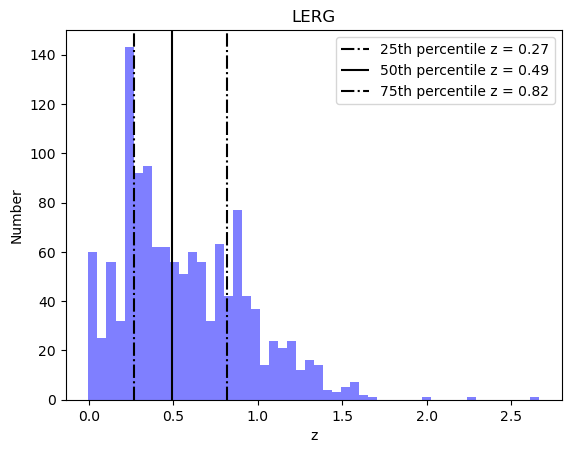

In [8]:
percentile_1 = 25
percentile_2 = 50
percentile_3 = 75
z_cut_1 = np.percentile(my_table['Z'], percentile_1)
z_cut_2 = np.percentile(my_table['Z'], percentile_2)
z_cut_3 = np.percentile(my_table['Z'], percentile_3)
ymax = 150

plt.hist(my_table['Z'], bins=50, color='blue', alpha = 0.5)
plt.xlabel('z')
plt.ylabel('Number')
plt.title(f'{Overall_class}')
plt.vlines(z_cut_1, ymin=0, ymax=ymax, colors='black', linestyles='-.', label = f'{percentile_1}th percentile z = {z_cut_1:.2f}')
plt.vlines(z_cut_2, ymin=0, ymax=ymax, colors='black', linestyles='-', label = f'{percentile_2}th percentile z = {z_cut_2:.2f}')
plt.vlines(z_cut_3, ymin=0, ymax=ymax, colors='black', linestyles='-.', label = f'{percentile_3}th percentile z = {z_cut_3:.2f}')
plt.legend()
plt.ylim(0,ymax)
#plt.xlim(0,2)

In [ ]:
print(np.min(my_table['Z']))

In [9]:
# Stack spectra in to redshift bins  - need to alter
Stacks = get_stack(Spec, zbins=[[0.03,0.4],[0.4,0.9],[0.9,3.5]])

# Save stack to CSV
stacks_df_1 = pd.DataFrame({'wave_spec_1': Stacks['zbin=0']['wln'], 'flux_spec_1': Stacks['zbin=0']['flux']})
stacks_df_2 = pd.DataFrame({'wave_spec_2': Stacks['zbin=1']['wln'], 'flux_spec_2': Stacks['zbin=1']['flux']})
stacks_df_3 = pd.DataFrame({'wave_spec_3': Stacks['zbin=2']['wln'], 'flux_spec_3': Stacks['zbin=2']['flux']})
stacks_df_1.to_csv(f'{Overall_class}_stacks_1.csv', index=False)
stacks_df_2.to_csv(f'{Overall_class}_stacks_2.csv', index=False)    
stacks_df_3.to_csv(f'{Overall_class}_stacks_3.csv', index=False)

flux_spec: [array([3.11101913, 1.8129257 , 0.64467525, ..., 1.09657812, 0.82680804,
        1.35462463])
 array([ 1.57528722, 14.48038387, 13.63597965, ...,  3.72738838,
         3.04531622,  2.78381109])
 array([3.88235617, 0.79981822, 8.12932873, ..., 3.52227926, 2.97236204,
        1.95745027])
 ...
 array([4.67603159, 3.70818067, 3.91442084, ..., 1.77768004, 1.03628993,
        0.82050562])
 array([12.96484756,  0.0982635 , -7.32406473, ...,  4.36094904,
         4.98617125,  5.86142969])
 array([-3.27908921, -6.90232038, -9.57117939, ...,  2.89561534,
         3.10111451,  2.48137331])                              ]
zbin: [[-0.5, 0.5], [0.5, 4.5]]
2
Number of spectra to stack =  663
-0.5 0.5
flux= [array([ 1.57528722, 14.48038387, 13.63597965, ...,  3.72738838,
         3.04531622,  2.78381109])
 array([3.88235617, 0.79981822, 8.12932873, ..., 3.52227926, 2.97236204,
        1.95745027])
 array([4.48935413, 0.87370813, 2.14574528, ..., 4.30969715, 4.49399233,
        4.33140802])


In [ ]:
# Read stack.csv
stacks_df_1 = pd.read_csv(f'{Overall_class}_stacks_1.csv')
stacks_1 = (stacks_df_1['wave_spec_1'].values, stacks_df_1['flux_spec_1'].values)

wln_1 = stacks_1[0] 
flux_1 = stacks_1[1]

stacks_df_2 = pd.read_csv(f'{Overall_class}_stacks_2.csv')
stacks_2 = (stacks_df_2['wave_spec_2'].values, stacks_df_2['flux_spec_2'].values)

wln_2 = stacks_2[0]
flux_2 = stacks_2[1]

stacks_df_3 = pd.read_csv(f'{Overall_class}_stacks_3.csv')
stacks_3 = (stacks_df_3['wave_spec_3'].values, stacks_df_3['flux_spec_3'].values)

wln_3 = stacks_3[0]
flux_3 = stacks_3[1]

## Plot Stacked Spectra

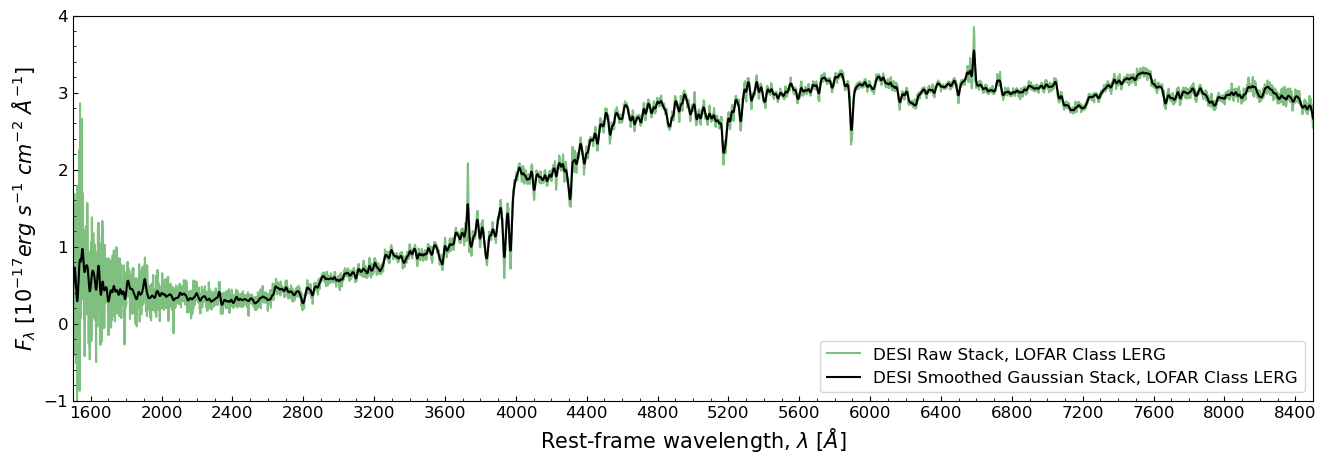

All plots saved in DESI-LERG-stack.pdf


In [10]:

# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stack_NEW.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln,flux, color='blue', alpha=0.5,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(wln,convolve(flux, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8000)
        ax.set_ylim(0,8)
        ax.set_xticks(range(1100, 8001, 500))
        ax.set_yticks(range(0, 8, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# All the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')



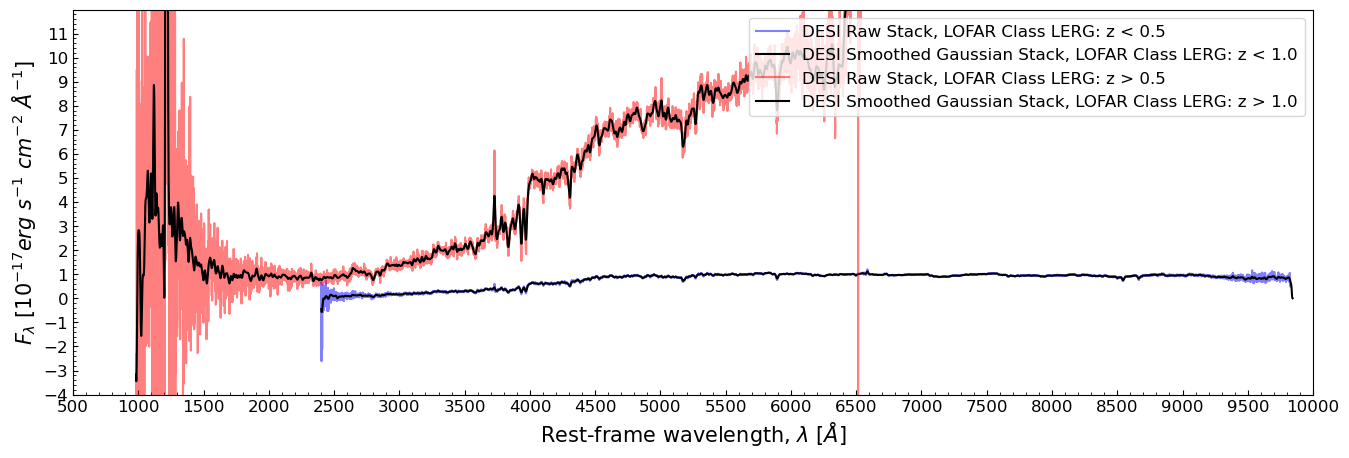

All plots saved in DESI-LERG-stacked-zbin-plots-practice.pdf


In [13]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-2.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1,flux_1, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1,convolve(flux_1, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2,flux_2, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2,convolve(flux_2, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3,flux_3, label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3,convolve(flux_3, Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(900,10000)
        ax.set_ylim(-2,10)
        ax.set_xticks(range(900, 10001, 500))
        ax.set_yticks(range(-2, 10, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

In [ ]:

"""

Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0.1
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)


st1 = bounds(wln_1)
st2 = bounds(wln_2)
st3 = bounds(wln_3)

In [ ]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-0.1cut.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(wln_1[st1[0]:st1[1]],flux_1[st1[0]:st1[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.03<z<0.4', color='blue', alpha=0.5)
        ax.plot(wln_1[st1[0]:st1[1]],convolve(flux_1[st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.03<z<0.4')
        ax.plot(wln_2[st2[0]:st2[1]],flux_2[st2[0]:st2[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.4<z<0.9', color='red', alpha=0.5)
        ax.plot(wln_2[st2[0]:st2[1]],convolve(flux_2[st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.4<z<0.9')
        ax.plot(wln_3[st3[0]:st3[1]],flux_3[st3[0]:st3[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: 0.9<z<3.5', color='green', alpha=0.5)
        ax.plot(wln_3[st3[0]:st3[1]],convolve(flux_3[st3[0]:st3[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: 0.9<z<3.5')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1100,8500)
        ax.set_ylim(-1,5)
        ax.set_xticks(range(1100, 8501, 500))
        ax.set_yticks(range(-1, 5, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

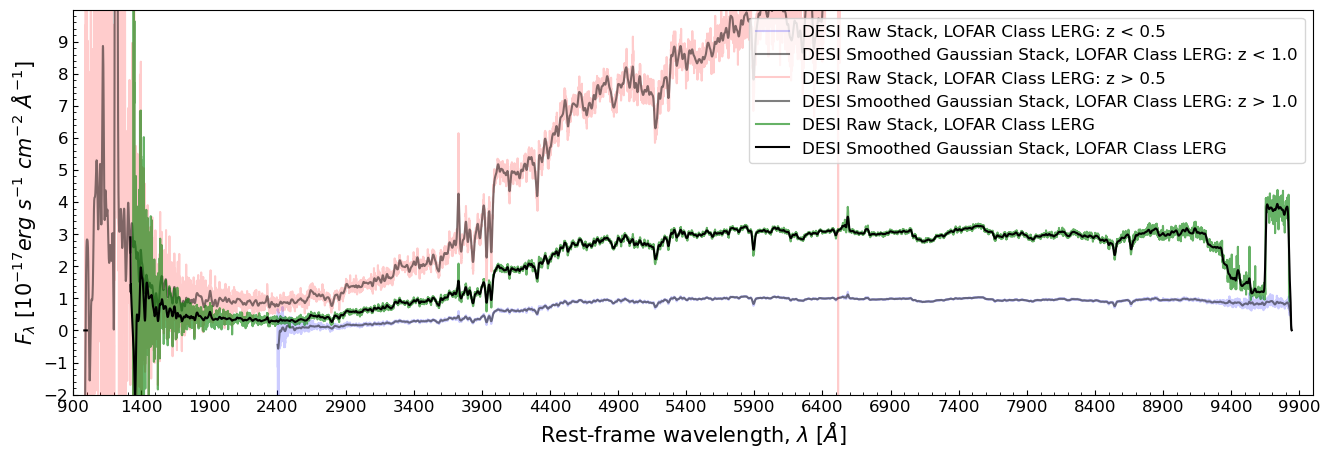

All plots saved in DESI-LERG-stacked-zbin-plots-practice.pdf


In [16]:
# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-practice.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(SFG_stacks['zbin=0']['wln'],SFG_stacks['zbin=0']['flux'], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z < 0.5', color='blue', alpha=0.2)
        ax.plot(SFG_stacks['zbin=0']['wln'],convolve(SFG_stacks['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z < 1.0')
        ax.plot(SFG_stacks['zbin=1']['wln'],SFG_stacks['zbin=1']['flux'], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z > 0.5', color='red', alpha=0.2)
        ax.plot(SFG_stacks['zbin=1']['wln'],convolve(SFG_stacks['zbin=1']['flux'], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z > 1.0')
        ax.plot(SFG_stack['zbin=0']['wln'],SFG_stack['zbin=0']['flux'], color='green', alpha=0.6,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(SFG_stack['zbin=0']['wln'],convolve(SFG_stack['zbin=0']['flux'], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(900,10000)
        ax.set_ylim(-2,10)
        ax.set_xticks(range(900, 10001, 500))
        ax.set_yticks(range(-2, 10, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()

# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')

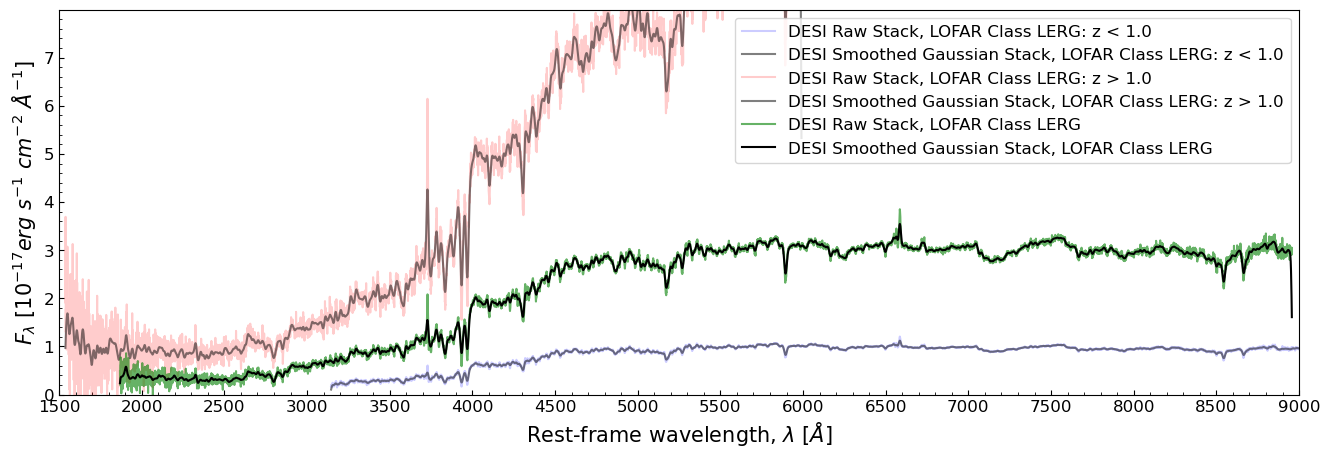

All plots saved in DESI-LERG-stacked-zbin-plots-all.pdf


In [19]:

"""
This crashes the kernel now ?
Add in some bounds to remove the upper and lower 10% of each spectra as noise reduction

"""

def bounds(stack_array):
        bound = 0.1
        l_bound = len(stack_array)*bound
        u_bound = len(stack_array)-(len(stack_array)*bound)

        return int(l_bound), int(u_bound)


st0 = bounds(SFG_stacks['zbin=0']['wln'])
st1 = bounds(SFG_stacks['zbin=1']['wln'])
st2 = bounds(SFG_stack['zbin=0']['wln'])



# Create a PDF file to save the plots
pdf_filename = f'DESI-{Overall_class}-stacked-zbin-plots-all.pdf'
with PdfPages(pdf_filename) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(SFG_stacks['zbin=0']['wln'][st0[0]:st0[1]],SFG_stacks['zbin=0']['flux'][st0[0]:st0[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z < 1.0', color='blue', alpha=0.2)
        ax.plot(SFG_stacks['zbin=0']['wln'][st0[0]:st0[1]],convolve(SFG_stacks['zbin=0']['flux'][st0[0]:st0[1]], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z < 1.0')
        ax.plot(SFG_stacks['zbin=1']['wln'][st1[0]:st1[1]],SFG_stacks['zbin=1']['flux'][st1[0]:st1[1]], label = f'DESI Raw Stack, LOFAR Class {Overall_class}: z > 1.0', color='red', alpha=0.2)
        ax.plot(SFG_stacks['zbin=1']['wln'][st1[0]:st1[1]],convolve(SFG_stacks['zbin=1']['flux'][st1[0]:st1[1]], Gaussian1DKernel(5)), color='black', alpha=0.5, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}: z > 1.0')
        ax.plot(SFG_stack['zbin=0']['wln'][st2[0]:st2[1]],SFG_stack['zbin=0']['flux'][st2[0]:st2[1]], color='green', alpha=0.6,label = f'DESI Raw Stack, LOFAR Class {Overall_class}')
        ax.plot(SFG_stack['zbin=0']['wln'][st2[0]:st2[1]],convolve(SFG_stack['zbin=0']['flux'][st2[0]:st2[1]], Gaussian1DKernel(5)), color='black', alpha=1, label = f'DESI Smoothed Gaussian Stack, LOFAR Class {Overall_class}')
        ax.set_ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
        ax.set_xlabel('Rest-frame wavelength, $\lambda$ [$\AA$]')
        ax.set_xlim(1500,9000)
        ax.set_ylim(0,8)
        ax.set_xticks(range(1500, 9001, 500))
        ax.set_yticks(range(0, 8, 1))
        ax.tick_params(axis='both', which='both', labelsize=12, direction = 'in')
        ax.minorticks_on()
        ax.legend(fontsize='large', loc = 'upper right')
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)

     # Save the current plot to the PDF file
        pdf.savefig(fig)
        plt.show()
        plt.close()


# After the loop, all the plots will be saved in the PDF file
print(f'All plots saved in {pdf_filename}')